# Circulation in the Arctic in ECCOv4r5

In [1]:
# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import cmocean


In [2]:
# Use this for the netcdf files stored on an s3 bucket
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()
        
        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
    
    return credentials
    

In [3]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False
        
    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'], 
                           token=credentials['sessionToken'])
    
    return s3, credentials

In [4]:
# function for determining the memory footprint of an object

# ... from https://stackoverflow.com/questions/449560/how-do-i-determine-the-size-of-an-object-in-python

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType

def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

## METHOD 1: LOADING FILES STORED ON A "LOCAL" DISK

### FIND THE GRANULES

Many ECCO V4r5 fields are stored on the /efs_ecco disk
```
Native Grid:
    monthly means    /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/
    daily snapshots  /efs_ecco/ECCO/V4/r5/netcdf/native/snap/
    geometry         /efs_ecco/ECCO/V4/r5/netcdf/native/geometry
    
Latlon Grid
    monthly means    /efs_ecco/ECCO/V4/r5/netcdf/latlon/mon_mean
    geometry         /efs_ecco/ECCO/V4/r5/netcdf/latlon/geometry
```

Let's start by opening and plotting one of these fields, 


### Locating monthly mean terms

In [5]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    print(str(i).zfill(3),d)

000 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/.ipynb_checkpoints
001 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ATM_SURFACE_TEMP_HUM_WIND_PRES
002 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_FRONT_FLUX
003 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/ICE_SHELF_FLUX
004 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_X
005 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_ADV_TEND_Y
006 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_X
007 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_DISS_TEND_Y
008 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X
009 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y
010 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_FW_FLUX
011 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_HEAT_FLUX
012 /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_AND_ICE_SURFACE_STRESS
013 /efs_ecco/ECCO/V4/r5/netcdf/nativ

### Locating monthly snapshots

In [6]:
# local path to monthly-snapshots native grid datasets
ecco_v4r5_mon_mean_native_snap_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/snap/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_snap_dataset_paths = np.sort(list(ecco_v4r5_mon_mean_native_snap_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_snap_dataset_paths):
    print(str(i).zfill(3),d)

000 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/OCEAN_BOTTOM_PRESSURE
001 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/OCEAN_TEMPERATURE_SALINITY
002 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/SEA_ICE_CONC_THICKNESS
003 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/SEA_ICE_VELOCITY
004 /efs_ecco/ECCO/V4/r5/netcdf/native/snap/SEA_SURFACE_HEIGHT


### Now, we read the datasets

#### Get the filenames for some dataset

In [7]:
# Select a dataset (the one containing temperature and salinity)
dataset_num_TS = 1
dataset_num_mom_flux = 22


print('selected ', ecco_v4r5_mon_mean_native_snap_dataset_paths[dataset_num_TS])
TS_dataset_dir = ecco_v4r5_mon_mean_native_snap_dataset_paths[dataset_num_TS]

print('selected ', ecco_v4r5_mon_mean_native_dataset_paths[dataset_num_mom_flux])
mom_flux_dataset_dir = ecco_v4r5_mon_mean_native_dataset_paths[dataset_num_mom_flux]


# make a list of all of the files in the directory
TS_dataset_files = np.sort(list(TS_dataset_dir.glob('*nc')))
mom_flux_dataset_files = np.sort(list(mom_flux_dataset_dir.glob('*nc')))


# show first 5 files
print('\nFirst file')
pprint([x.name for x in TS_dataset_files[:1]])
pprint([x.name for x in mom_flux_dataset_files[:1]])



selected  /efs_ecco/ECCO/V4/r5/netcdf/native/snap/OCEAN_TEMPERATURE_SALINITY
selected  /efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_VOLUME_FLUX

First file
['OCEAN_TEMPERATURE_SALINITY_snap_1992-01-02T000000_ECCO_V4r5_native_llc0090.nc']
['OCEAN_VOLUME_FLUX_mon_mean_1992-01_ECCO_V4r5_native_llc0090.nc']



#### Connect to Dask client

Started a dask client (left side of JupyterHub panel), and connect to it (click <>)

In [8]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:35413")
client.ncores
client.restart()

Task exception was never retrieved
future: <Task finished name='Task-23139' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-23217' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:2394> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py", line 2403, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-23216' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/p

#### Load the grid

In [9]:
# local path to monthly-mean native grid datasets
ecco_v4r5_mon_mean_native_grid_dir = Path('/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')

# list sub-directories (one per dataset)
ecco_v4r5_mon_mean_native_grid_paths = np.sort(list(ecco_v4r5_mon_mean_native_grid_dir.glob('*')))

for i, d in enumerate(ecco_v4r5_mon_mean_native_grid_paths):
    print(str(i).zfill(3),d)


000 /efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc


In [10]:
ecco_grid = xr.open_dataset(str(ecco_v4r5_mon_mean_native_grid_paths[0]))
ecco_grid

<xarray.Dataset> Size: 92MB
Dimensions:                 (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50,
                             k_l: 50, k_p1: 51, tile: 13, nbh: 4, nv: 2)
Coordinates: (12/20)
  * i                       (i) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i_g                     (i_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j                       (j) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * j_g                     (j_g) int32 360B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * k                       (k) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * k_u                     (k_u) int32 200B 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
    ...                      ...
    Zp1                     (k_p1) float32 204B ...
    Zu                      (k_u) float32 200B ...
    Zl                      (k_l) float32 200B ...
    XC_bnds                 (tile, j, i, nbh) float32 2MB ...
    YC_bnds                 (tile, j, i, nbh) float32 2MB ...
    Z_bnds                  (k, nv) float32 400B ...
Dimensions without coordinates: nbh, nv
Data variables: (12/29)
    CS                      (tile, j, i) float32 421kB ...
    SN                      (tile, j, i) float32 421kB ...
    rA                      (tile, j, i) float32 421kB ...
    dxG                     (tile, j_g, i) float32 421kB ...
    dyG                     (tile, j, i_g) float32 421kB ...
    Depth                   (tile, j, i) float32 421kB ...
    ...                      ...
    dyF                     (tile, j, i) float32 421kB ...
    dyU                     (tile, j_g, i_g) float32 421kB ...
    rLowC                   (tile, j, i) float32 421kB ...
    rSurfC                  (tile, j, i) float32 421kB ...
    ocean_column_thickness  (tile, j, i) float32 421kB ...
    ice_shelf_draft         (tile, j, i) float32 421kB ...
Attributes: (12/61)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    creator_email:                   ecco-group@mit.edu
    ...                              ...
    source:                          The ECCO state estimate was produced by ...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters - llc90 Grid (V...
    uuid:                            ef749a0c-e985-11ed-a16e-0242ac110002
    coordinates_comment:             Note: the global 'coordinates' attribute...

### Volume
Calculate the volume of each grid cell. This is used when converting advective and diffusive flux convergences and calculating volume-weighted averages.

In [11]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()

### Load monthly snapshots

In [12]:
%%time
year_start = 1993
year_end = 2019


ecco_monthly_TS = xr.open_mfdataset(TS_dataset_files, 
                          parallel=True, data_vars=['THETA'],\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})

# time mask for snapshots
time_snap_mask = np.logical_and(ecco_monthly_TS.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_TS.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))

ecco_monthly_TS = ecco_monthly_TS.isel(time=time_snap_mask)

CPU times: user 58.6 s, sys: 3.53 s, total: 1min 2s
Wall time: 8min 28s


In [13]:
# 1993-01 (beginning of first month) to 2020-01-01 (end of last month, 2019-12)
print(ecco_monthly_TS.THETA.time.isel(time=[0, -1]).values)

['1993-01-01T00:00:00.000000000' '2019-12-31T00:00:00.000000000']


In [14]:
# Find the record of the last snapshot
## This is used to defined the exact period for monthly mean data 
last_record_date = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(ecco_monthly_TS.time[-1].values)
print(last_record_date)

(2019, 12, 31, 0, 0, 0)


### Load monthly mean data 

In [15]:
## Open ECCO monthly mean variables

ecco_vars_int = xr.open_mfdataset(mom_flux_dataset_files, 
                          parallel=True, data_vars='minimal',\
                          coords='minimal',compat='override',
                          combine='nested', concat_dim='time',
                          chunks={'time':12, 'tile':13,' k':50,'j':90,'i':90})


# time mask for monthly means
time_mean_mask = np.logical_and(ecco_vars_int.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_vars_int.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))

ecco_vars_int = ecco_vars_int.isel(time=time_mean_mask)

In [16]:
# Print first and last time points of the monthly-mean records
print(ecco_vars_int.time.isel(time=[0, -1]).values)

['1993-01-16T12:00:00.000000000' '2019-12-16T00:00:00.000000000']


Each monthly mean record is bookended by a snapshot. We should have one more snapshot than monthly mean record.

In [17]:
print('Number of monthly mean records: ', len(ecco_vars_int.time))
print('Number of monthly snapshot records: ', len(ecco_monthly_TS.time))

Number of monthly mean records:  324
Number of monthly snapshot records:  9861


In [18]:
# Drop superfluous coordinates (We already have them in ecco_grid)
ecco_vars_int = ecco_vars_int.reset_coords(drop=True)

### Create the xgcm 'grid' object

The `xgcm` 'grid' object is used to calculate the flux divergences across different tiles of the lat-lon-cap grid and the time derivatives from ``THETA`` snapshots

In [19]:
# Change time axis of the snapshot variables
ecco_vars_int.time.attrs['c_grid_axis_shift'] = 0.5

In [20]:
grid = ecco.get_llc_grid(ecco_grid)

In [21]:
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * right    k_u --> center
  * left     k_l --> center
  * outer    k_p1 --> center

In [22]:
ecco_monthly_TS.THETA.isel(k=18).Z.values

array(-257.47, dtype=float32)

### Mean tempereature at 257 m depth

In [23]:
mean_theta = ecco_monthly_TS.THETA.isel(k=18).mean('time').compute()

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 23.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


### Mean circulation at depth 257 m

In [25]:
ecco_vars_int

<xarray.Dataset> Size: 20GB
Dimensions:   (time: 324, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
               k_l: 50, k_u: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates:
  * i         (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g       (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j         (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g       (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * k         (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u       (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * k_l       (k_l) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * k_p1      (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * tile      (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time      (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16
Dimensions without coordinates: nv, nb
Data variables:
    UVELMASS  (time, k, tile, j, i_g) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 45), meta=np.ndarray>
    VVELMASS  (time, k, tile, j_g, i) float32 7GB dask.array<chunksize=(1, 25, 13, 45, 90), meta=np.ndarray>
    WVELMASS  (time, k_l, tile, j, i) float32 7GB dask.array<chunksize=(1, 25, 13, 90, 90), meta=np.ndarray>
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty, Ou Wang, Ichiro Fukumori
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Volume Fluxes - Monthly Mean ...
    uuid:                            b2c0cc44-271c-11f0-9807-0a58a9feac02

In [75]:
uvel = ecco_vars_int.UVELMASS.isel(k=18).mean('time').compute()
vvel = ecco_vars_int.VVELMASS.isel(k=18).mean('time').compute()

In [77]:
# Interpolate u and v to the center
u_center = grid.interp(uvel, 'Y').compute()
v_center = grid.interp(vvel, 'X').compute()

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


### Depth 

In [62]:
depth = ecco_grid.Depth.load()

In [63]:
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='grey')

In [67]:
# Define spatial boundaries of the Arctic

#Arctic Ocean
control_lats = [65, 90, 90, 65]
control_lons = [-180, -180, 180, 180]

In [71]:
depth = depth.where((depth.XC>=np.min(control_lons))&(depth.XC<=np.max(control_lons))&\
              (depth.YC>=np.min(control_lats))&(depth.YC<=np.max(control_lats)))

In [80]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


ValueError: x, y, u and v must be 1 or 2 dimensional

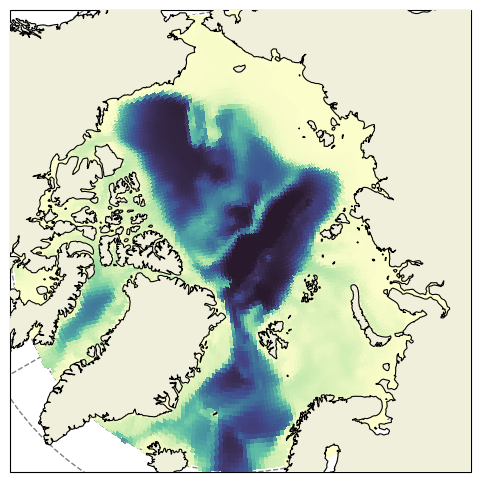

In [83]:
%%time

plt.figure(figsize=[12,6]);
f, ax, p, cbar, new_grid_lon_centers_out, new_grid_lat_centers_out,\
        data_latlon_projection_out, gl = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, 
                              ecco_grid.YC, 
                              -1*depth*1e-3, 
                              projection_type='stereo',
                              plot_type='pcolormesh',     
                              cmin=0, cmax=4,
                              cmap=cmocean.cm.deep,                                         
                              lat_lim=65,
                              user_lon_0=0, show_colorbar=False)

ax.quiver(ecco_grid.XG, ecco_grid.YG, uvel, vvel, scale=1e1, width=0.002,
         transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(land_50m, zorder=75) 

# Add a colorbar axis at the bottom of the graph
cbar_ax = f.add_axes([0.31, 0.02, 0.4, 0.02])

# Draw the colorbar
cbar=f.colorbar(p, cax=cbar_ax,orientation='horizontal', ticks=np.linspace(0,4,11))
cbar.set_label(r'Depth [km]', labelpad=5, fontsize=14)
cbar.ax.tick_params(labelsize=12)

# plt.savefig('figs/arctic_depth_v4r5.png', format='png', bbox_inches='tight', dpi=300)

CPU times: user 3.05 s, sys: 225 ms, total: 3.27 s
Wall time: 3.27 s


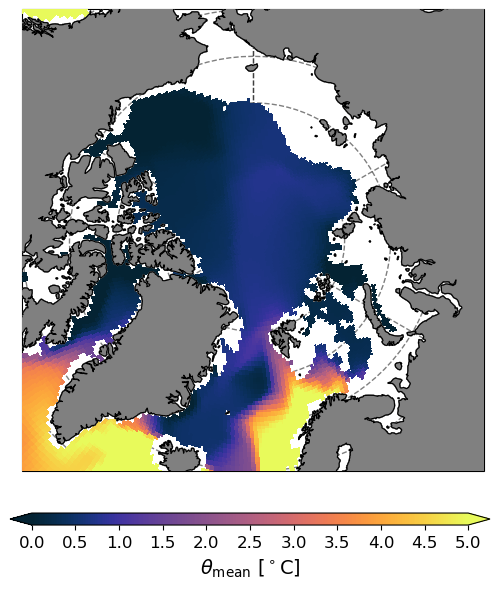

In [61]:
%%time

plt.figure(figsize=[12,6]);
f, ax, p, cbar, new_grid_lon_centers_out, new_grid_lat_centers_out,\
        data_latlon_projection_out, gl = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, 
                              ecco_grid.YC, 
                              mean_theta, 
                              projection_type='stereo',
                              plot_type='pcolormesh',     
                              cmin=0, cmax=5,
                              cmap=cmocean.cm.thermal,                                         
                              lat_lim=65,
                              user_lon_0=0, show_colorbar=False)

ax.coastlines()
ax.add_feature(land_50m, zorder=75) 

# Add a colorbar axis at the bottom of the graph
cbar_ax = f.add_axes([0.31, 0.02, 0.4, 0.02])

# Draw the colorbar
cbar=f.colorbar(p, cax=cbar_ax,orientation='horizontal', ticks=np.linspace(0,5,11), extend='both')
cbar.set_label(r'$\theta_\text{mean}$ [$^\circ$C]', labelpad=5, fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.savefig('figs/arctic_theta_mean_v4r5.png', format='png', bbox_inches='tight', dpi=300)

In [104]:
u_smooth = u_center.coarsen(tile=6, j_g=3, i_g=3, boundary='trim').mean()
v_smooth = v_center.coarsen(tile=6, j_g=3, i_g=3, boundary='trim').mean()

# Same for lat/lon if needed
lon_smooth = ecco_grid.XG.coarsen(tile=6, j_g=3, i_g=3, boundary='trim').mean()
lat_smooth = ecco_grid.YG.coarsen(tile=6, j_g=3, i_g=3, boundary='trim').mean()


In [105]:
skip = (slice(None, None, 2), slice(None, None, 2))  # every 2nd point

ValueError: too many values to unpack (expected 2)

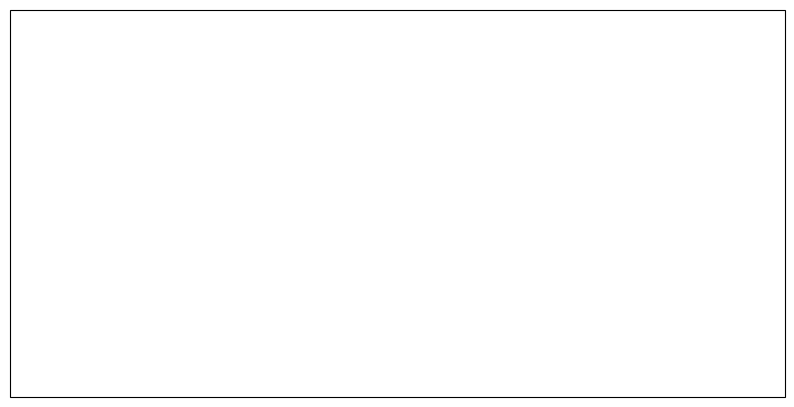

In [106]:

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))

ax.quiver(
    lon_smooth.values[skip],
    lat_smooth.values[skip],
    u_smooth.values[skip],
    v_smooth.values[skip],
    scale=10,               # adjust to control arrow length
    scale_units='inches',
    width=0.002
)

ax.coastlines()
ax.set_title('Smoothed Velocity Vectors')
plt.show()